# MSDS 7331 - Project 2
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Project_2

### Tasks

Ryan:
1. bring over pre-processing code <font color="green">DONE!</font>
2. Create a function to pass in:
    * target data y
    * explanatory data X
    * Stratified K-fold cross validation object
    * Model
    * grid search parameters


Dineen:
1. dividing your data into training and testing splits


Dale:
1. Gridsearch

## Put your iterative learning here. Everytime you go through the code and learned something make a bullet point:
* Example

In [3]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# other
import time
import warnings

<hr>
#### Variable Notes:
AGE - This variable is right skewed with a range from age 21 to 79. The average age is 35 with the median at 34. This variable is clean of outliers.

Bill Amount (BILL_AMT1_Sept - BILL_AMT6_April) - The amount of the credit card bill in Taiwan Dollar for the months April 2005 to September2015. The bill amounts across the months are highly correlated.

EDUCATION - Undergraduate degree (University) is the most common education level at 46.8%. The majority of observations (82.1%) are from individuals with an undergraduate degree (University) or better.

LIMIT_BAL - Ranges from 10k to 1mm with a median of 140k. The values are right skewed, however, no unreasonable looking outliers. The total credit limit extended to the sample is over five billion.

MARRIAGE - Single makes up the largest group at 53.2%, then Married at 45.5%, and lastly an Others group of 1.3%

Pay History (PAY_0_Sept - PAY_6_April) - The 3rd quartile for each month is zero meaning, most observations are zero or less. One month delays seem to be far more absent in months PAY_2_Aug to PAY_6_April, with PAY_5_May, PAY_6_April not having any at all and seems rather odd. Only PAY_0_Sept of 1 seems to fit as one would expect. As mentioned previously, the provided documentation does not explain the values of -2 and 0, but it can be inferred as not negative events. To resolve these problems, one solution would be to create a variable called **has_Pay_Delay** history and consolidate it to a binary TRUE/FALSE variable and, thereby, removing the month in which it occurred. 

Pay Amount (PAY_AMT1_Sept - PAY_AMT6_April) - Is the amount of the payment toward the credit card that month. About a fifth of the observations are zeros each month.

SEX - Females are the majority gender at 60.4%.

AGE_range - Variable was created by bracketing the ages from the AGE variable by 10 years ('21-30', '31-40', '41-50', '51-60', '61-70', '71-80+'). Seventy-two percent of the observations fall in to the first two categories "21-30" and "31-40."

default payment next month - This is a binary variable of 0 or 1. 22.1% of the obeservations were considered in default in October 2005 and this is the sample average.


#### Description of the Data per Offical Documentation
**LIMIT_BAL** (Ratio): Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
**SEX** (Nominal): Gender (1 = male; 2 = female)<br>
**EDUCATION** (Nominal): Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)<br>
**MARRIAGE** (Nominal): Marital status (1 = married; 2 = single; 3 = others)<BR>
**AGE** (Interval): Age (year)<BR>
**PAY_0_Sept - PAY_6_April** (Ordinal): History of past payment. The past monthly payment records (from April to September, 
2005). The measurement scale for the repayment status is: <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-1 = pay duly<BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 - 8 = payment delay for one to eight months <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9 = payment delay for nine months and above<BR>
**BILL_AMT1_Sept - BILL_AMT6_April** (Ratio): Amount of bill statement (NT dollar) <BR>
**PAY_AMT1_Sept - PAY_AMT6_April** (Ratio): Amount of previous payment (NT dollar) <BR>
**default payment next month** (Nominal): default payment (Yes = 1, No = 0)

### Data Preparation (15 points total)
* [10 points] Define and prepare your class variables. Use proper variable
representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for
dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for
the analysis.

* The following were converted 'AGE', 'SEX','MARRIAGE', 'LIMIT_BAL': 
  * One hot encoding of MARRIAGE
  * SEX was converted to isMale
  * AGE was converted to age ranges
  * LIMIT_BAL was converted to limit ranges
* We use scaled data (Standard Scaled) to bring the payment levels and monthly counts into a common scale
* We will use StratifiedKFold to create mulitple train/test data sets for cross validation
  * We have enough samples that we do not see any weakness of using StratifiedKFold
* We use manually selected attributes for a Logistic Model to improve the fit
  * Here we will try PCA
  * We will use Pipelines to match the attribute reduction with the model

* We will use GridSearch to look for optimal parameters for various models, including visualization
of the parameters and their resulting models

* We will use ROC Curves and AUC scores to decide on the best model
* We will use visulazations throughout, but especially in justyfying our model selection
* We will document the most important attributes


In [4]:
# First row are for reference with header starting on line 2.
# ID field is use as the index field in the data frame
# Month specific columns renamed with month for readability

cc_data = (pd.read_excel("./cc_data/default of credit card clients.xls", skiprows=1, index_col='ID')
             .rename(columns={'PAY_0':'PAY_0_Sept', #No Pay_1
                              'PAY_2':'PAY_2_Aug', # change 'this':'to that'
                              'PAY_3':'PAY_3_July', 
                              'PAY_4':'PAY_4_June',
                              'PAY_5':'PAY_5_May',
                              'PAY_6':'PAY_6_April',
                              'BILL_AMT1':'BILL_AMT1_Sept', 
                              'BILL_AMT2':'BILL_AMT2_Aug', 
                              'BILL_AMT3':'BILL_AMT3_July', 
                              'BILL_AMT4':'BILL_AMT4_June', 
                              'BILL_AMT5':'BILL_AMT5_May',
                              'BILL_AMT6':'BILL_AMT6_April', 
                              'PAY_AMT1':'PAY_AMT1_Sept', 
                              'PAY_AMT2':'PAY_AMT2_Aug', 
                              'PAY_AMT3':'PAY_AMT3_July', 
                              'PAY_AMT4':'PAY_AMT4_June', 
                              'PAY_AMT5':'PAY_AMT5_May',
                              'PAY_AMT6':'PAY_AMT6_April'
                             })
             # Due to the many age values, creating ordinal age brackets
             # '21-30':0,
             # '31-40':1,
             # '41-50':2, 
             # '51-60':3,
             # '61-70':4,
             # '71-80+':5
             .assign(AGE_range = lambda x: pd.cut(x['AGE'],[20,30,40,50,60,70,120], 6, 
                                                 labels=[0,1,2,3,4,5]).astype(int))
             # this creates a new variable for LIMIT_BAL_brackets and drop 'LIMIT_BAL'
             .assign(LIMIT_BAL_range = lambda x: pd.cut(x['LIMIT_BAL'],[0,250000,500000,750000,1e7], 4, 
                                                 labels=[0,1,2,3]).astype(int))
             .drop(['LIMIT_BAL'], axis=1)
             # Male = 1 and Female = 2, this creates binary 0 or 1 feature if male
             .assign(isMale = lambda x: x['SEX'] == 1) 
             .assign(MARRIAGE = lambda x: x['MARRIAGE'].apply({1:'Married', 
                                                               2:'Single',
                                                               3:'Others'}.get))
                                                        
           )

# drop rows with missing marriage indicator. Loss of 54 rows to 29,946
cc_data = cc_data[cc_data['MARRIAGE'].isin(['Married','Single','Others'])] 

# Make dummies from marriage and drop marriage column
cc_data = (pd.concat((cc_data,
                     pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                    axis=1)
           .drop('MARRIAGE', axis=1)
           )

# drop undocumented 'Education' values. Loss of 345 rows to 29,601
# Impute undefined values. "~" symbol means to invert. Or for the below "not in"
cc_data = cc_data[cc_data['EDUCATION'].isin([1,2,3,4])]

# Remap to ordinal numbering from:
# 1:'Graduate School', 
# 2:'University',
# 3:'High School',
# 4:'Others'
# to:
# 'High School':0,
# 'University':1,
# 'Graduate School':2, 
# 'Others':3
cc_data = cc_data.assign(EDUCATION = lambda x: x['EDUCATION'].apply({1:2, 
                                                                     2:1,
                                                                     3:0,
                                                                     4:3}.get))

print(cc_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29601 entries, 1 to 30000
Data columns (total 28 columns):
SEX                           29601 non-null int64
EDUCATION                     29601 non-null int64
AGE                           29601 non-null int64
PAY_0_Sept                    29601 non-null int64
PAY_2_Aug                     29601 non-null int64
PAY_3_July                    29601 non-null int64
PAY_4_June                    29601 non-null int64
PAY_5_May                     29601 non-null int64
PAY_6_April                   29601 non-null int64
BILL_AMT1_Sept                29601 non-null int64
BILL_AMT2_Aug                 29601 non-null int64
BILL_AMT3_July                29601 non-null int64
BILL_AMT4_June                29601 non-null int64
BILL_AMT5_May                 29601 non-null int64
BILL_AMT6_April               29601 non-null int64
PAY_AMT1_Sept                 29601 non-null int64
PAY_AMT2_Aug                  29601 non-null int64
PAY_AMT3_July           

In [5]:
# Seperate target data and explanatory data to NumPy arrays
# ***Alert*** Changed variable names
y = cc_data['default payment next month'].values
X = cc_data.drop('default payment next month', axis='columns').values

# Column names for labeling
X_names = cc_data.drop('default payment next month', axis='columns').columns

In [6]:
# Source: Python Machine Learning by Sebastian Raschka
# Create train and test sets using 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=1)

In [46]:
# Source: Python Machine Learning by Sebastian Raschka
# estimator pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

###############################################################################
########################## Logistic Regression Pipe ###########################
###############################################################################
clf_name='Logistic Regression'
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', LogisticRegression(random_state=1))])
param_grid_lr = [{'pca__n_components':[1,2,3,4],
                  'clf__C': [.1,1,10,100,1000],
                  'clf__penalty': ['l1','l2'],
                  'clf__class_weight': ['balanced', None]}]
payload_lr = [clf_name, pipe_lr, param_grid_lr]

###############################################################################
################################## KNN Pipe ###################################
###############################################################################
clf_name='K Nearest Neighbors'
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', KNeighborsClassifier())])

param_grid_knn = [{'pca__n_components':[1,2,3,4],
                   'clf__n_neighbors': np.arange(1, 11, 1), # Series of 1 to 10
                   'clf__p': [1,2]}]

payload_knn = [clf_name, pipe_knn, param_grid_knn]


###############################################################################
############################## Randomforest Pipe ##############################
###############################################################################
# No need to scale on RF
clf_name='Random Forest'
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=1,
                                                   n_jobs=1))])

param_grid_rf = [{'clf__criterion': ['entropy','gini'],
                  'clf__n_estimators': [50, 75, 100, 125, 150], 
                  'clf__max_features': ['auto', 'sqrt', 'log2', None],
                  'clf__class_weight': ['balanced', 'balanced_subsample', None]}]

payload_rf = [clf_name, pipe_rf, param_grid_rf]

In [50]:
# Source: Python Machine Learning by Sebastian Raschka
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

# http://scikit-learn.org/stable/modules/model_evaluation.html
"""
Per documentation on Scikit-Learn regarding cross validation (cv) parameter, 
"For integer/None inputs, if y is binary or multiclass, StratifiedKFold used. If the 
estimator is a classifier or if y is neither binary nor multiclass, KFold is used."
"""

def grid_searcher2(X, y, payload):
    X_train, X_test, y_train, y_test = \
                            train_test_split(X, y, test_size=0.20, random_state=1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs = GridSearchCV(estimator=payload[1], 
                          param_grid=payload[2], 
                          scoring='f1', 
                          cv=10,
                          n_jobs=-1)

        gs = gs.fit(X_train, y_train)
        print(gs.best_score_)
        print(gs.best_params_)
        print(gs.best_estimator_)
    return gs

# Run Logistic Regression, KNN, and Random Forest Models
gs_lr = grid_searcher2(X, y, payload_lr)
gs_knn = grid_searcher2(X, y, payload_knn)
#gs_rf = grid_searcher2(X, y, payload_rf)

0.439736744205
{'clf__C': 10, 'clf__class_weight': 'balanced', 'pca__n_components': 3, 'clf__penalty': 'l1'}
Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('clf', LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
0.395256546175
{'pca__n_components': 3, 'clf__p': 1, 'clf__n_neighbors': 7}
Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=1,
           weights='uniform'))])


In [55]:
%matplotlib inline
# Source: Python Machine Learning by Sebastian Raschka
# Create train and test sets using 80/20 split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=1)

# Make ROC Curve
def roc_data(gs, X_train, y_train, X_test, y_test):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        best_clf = gs.best_estimator_
        best_clf.fit(X_train, y_train)
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        y_pred = best_clf.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    return fpr, tpr

fpr_lr, tpr_lr = roc_data(gs_lr, X_train, y_train, X_test, y_test)
fpr_knn, tpr_knn = roc_data(gs_knn, X_train, y_train, X_test, y_test)
fpr_rf, tpr_rf = roc_data(gs_rf, X_train, y_train, X_test, y_test)


Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.66      0.75      4611
          1       0.34      0.63      0.45      1310

avg / total       0.75      0.65      0.68      5921


Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.93      0.87      4611
          1       0.55      0.30      0.39      1310

avg / total       0.76      0.79      0.77      5921


Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4611
          1       0.66      0.37      0.47      1310

avg / total       0.80      0.82      0.80      5921



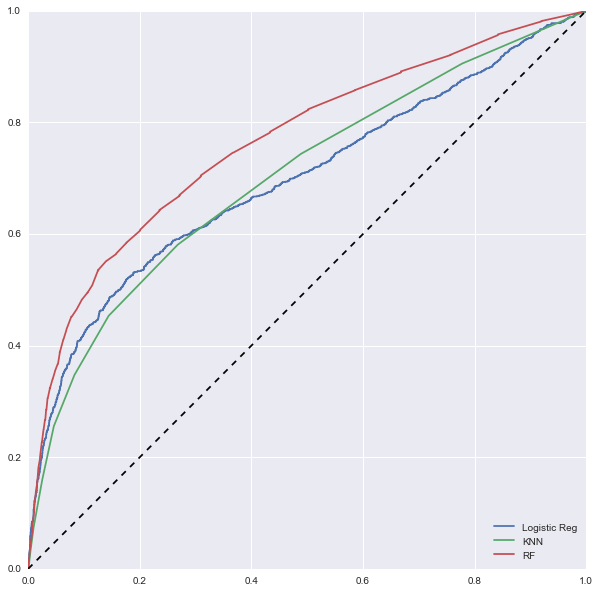

In [33]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.plot(fpr_lr, tpr_lr, label='Logistic Reg')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.show()


In [34]:
gs_lr.best_estimator_

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('clf', LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [39]:
#******************************************************************************
#***************************** K Fold Parameters ******************************
#******************************************************************************

############################ Logistic Regression ##############################
clf_name='Logistic Regression'
kf_payload_lr = [clf_name, gs_lr.best_estimator_]

#################################### KNN ######################################
clf_name='K Nearest Neighbors'
kf_payload_knn = [clf_name, gs_knn.best_estimator_]

################################ Random Forest ################################
# Shouldn't scale on RF
clf_name='Random Forest'
kf_payload_rf = [clf_name, gs_rf.best_estimator_]

In [38]:
# Could use cross_val_score instead
# Cross Validation Object
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                           n_folds=10,
                           random_state=1)

# Source: Python Machine Learning by Sebastian Raschka
def kfold_estimator(X_train, y_train, kfold, pipe_payload):
    clf_name = pipe_payload[0] # assigns name
    pipe = pipe_payload[1] # assigns pipeline
    scores = []
    print(clf_name)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for k, (train, test) in enumerate(kfold):
            pipe.fit(X_train[train], y_train[train])
            score = pipe.score(X_train[test], y_train[test])
            scores.append(score)
            print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
                  np.bincount(y_train[train]), score))

    print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print()
    return [clf_name, np.mean(scores), np.std(scores)]
    
metrics_lr = kfold_estimator(X_train, y_train, kfold, kf_payload_lr)
metrics_knn = kfold_estimator(X_train, y_train, kfold, kf_payload_knn)
metrics_rf = kfold_estimator(X_train, y_train, kfold, kf_payload_rf)

Logistic Regression
Fold: 1, Class dist.: [16546  4765], Acc: 0.643
Fold: 2, Class dist.: [16546  4765], Acc: 0.637
Fold: 3, Class dist.: [16546  4765], Acc: 0.633
Fold: 4, Class dist.: [16546  4765], Acc: 0.656
Fold: 5, Class dist.: [16546  4765], Acc: 0.642
Fold: 6, Class dist.: [16547  4766], Acc: 0.651
Fold: 7, Class dist.: [16547  4766], Acc: 0.653
Fold: 8, Class dist.: [16547  4766], Acc: 0.636
Fold: 9, Class dist.: [16547  4766], Acc: 0.640
Fold: 10, Class dist.: [16547  4766], Acc: 0.656

CV accuracy: 0.645 +/- 0.008

K Nearest Neighbors
Fold: 1, Class dist.: [16546  4765], Acc: 0.795
Fold: 2, Class dist.: [16546  4765], Acc: 0.789
Fold: 3, Class dist.: [16546  4765], Acc: 0.789
Fold: 4, Class dist.: [16546  4765], Acc: 0.799
Fold: 5, Class dist.: [16546  4765], Acc: 0.798
Fold: 6, Class dist.: [16547  4766], Acc: 0.790
Fold: 7, Class dist.: [16547  4766], Acc: 0.788
Fold: 8, Class dist.: [16547  4766], Acc: 0.784
Fold: 9, Class dist.: [16547  4766], Acc: 0.786
Fold: 10, Class 

In [40]:
print(metrics_lr,
metrics_knn,
metrics_rf)

['Logistic Regression', 0.64489122721792158, 0.0081786018371061784] ['K Nearest Neighbors', 0.79100387111869386, 0.0047520776648847839] ['Random Forest', 0.81009274670378884, 0.0065515445805953481]


In [ ]:
# *** Dale I split this cell and put the above in one just for the separating the data ***

#PCA or LDA code
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.lda import LDA

#copy the data to use code from sample
# X = cc_data_Xs
# y = cc_data_target
target_names = cc_data_Xs_names

pca = PCA(n_components=4)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=4)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

In [ ]:
%matplotlib inline
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, cc_data_Xs_names) 
lda_weight_strings = get_feature_names_from_weights(lda.scalings_.T, cc_data_Xs_names) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_lda = pd.DataFrame(X_lda,columns=[lda_weight_strings])

from pandas.tools.plotting import scatter_plot

print(pca_weight_strings[0])
print(pca_weight_strings[1])
print(pca_weight_strings[2])
print(pca_weight_strings[3])
print(lda_weight_strings)
# plot is broken.
# scatter plot the output, with the names created from the weights
ax = scatter_plot(df_pca, pca_weight_strings[0], pca_weight_strings[1])
newfig = plt.figure()
#ax = scatter_plot(df_lda, 'x', 'x')
plt.show()

### Data Preparation (15 points total) - part 2

* [5 points] Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created).

<font color='Red'>Not Complete</font>


#### Convert data to numpy arrays for training

### Modeling and Evaluation (70 points total)

* [10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s)
appropriate for analyzing the results of your modeling? Give a detailed explanation
backing up any assertions.

<font color='Red'>Not Complete</font>

    ROC Curves and AUC scores are good measures for imbalanced data scources. "The main goal for learning from imbalanced datasets is to improve the recall without hurting the precision...The F-value metric is one measure that combines the trade-offs of precision and recall, and outputs a single number reflecting the "goodness" of a classifier in the presence of rare classes. "
    https://www3.nd.edu/~dial/publications/chawla2005data.pdf

    From Wikipedia:
    "Precision (also called positive predictive value) is the fraction of retrieved instances that are relevant"
    "Recall (also known as sensitivity) is the fraction of relevant instances that are retrieved."
    https://en.wikipedia.org/wiki/Precision_and_recall

In [ ]:
# Find a evaluation metric the is compareable for binary and multiclassification 

* [10 points] Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For
example, if you are using time series data then you should be using continuous training
and testing sets across time.

<font color='Red'>Not Complete</font>


* [20 points] Create three different classification/regression models for each task (e.g.,
random forest, KNN, and SVM for task one and the same or different algorithms for
task two). Two modeling techniques must be new (but the third could be SVM or
logistic regression). Adjust parameters as appropriate to increase generalization
performance using your chosen metric. You must investigate different parameters
of the algorithms!

<font color='Red'>Not Complete</font>

In [ ]:
# The three different classifications we will use will be logistic regression, random forest, and KNN
# *** Do not use scaling on Random Forest - it doesn't need it***

# Task 2 find alternative prediction to default; find 3 levels of risk groups, high, medium, low

# Apply gridsearchCV

* [10 points] Analyze the results using your chosen method of evaluation. Use
visualizations of the results to bolster the analysis. Explain any visuals and analyze why
they are interesting to someone that might use this model.

<font color='Red'>Not Complete</font>

In [ ]:
# Draw the ROC for default evaluation

# Show something else for the risk grouping

* [10 points] Discuss the advantages of each model for each classification task, if any. If
there are not advantages, explain why. Is any model better than another? Is the
difference significant with 95% confidence? Use proper statistical comparison methods.
You must use statistical comparison techniques—be sure they are appropriate for your
chosen method of validation as discussed in unit 7 of the course.

<font color='Red'>Not Complete</font>

In [ ]:
# Look more into this later

* [10 points] Which attributes from your analysis are most important? Use proper
methods discussed in class to evaluate the importance of different attributes. Discuss
the results and hypothesize about why certain attributes are more important than others
for a given classification task.

<font color='Red'>Not Complete</font>

In [ ]:
# Figure this out later

Deployment (5 points total)
* How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it for prediction)? How would you measure the model's value if it
was used by these parties? How would your deploy your model for interested parties?
What other data should be collected? How often would the model need to be updated,
etc.?

<font color='Red'>Not Complete</font>
* The models provide a starting point for interested parties, identifying the most fruitful models with the data available. From this point, a conversation would be in order with the prospective model users about additional data that would enhance predictions and cover corner cases, and request additional data to test and validate again. 
* To measure the value, one would implement the model in a business setting. This is envisioned as  customer advisers calling customers that are going to default to offer help or whatever action the business sees fit to take to avoid that outcome. At the point where the CC company has fewer defaults and people have fewer defaults to struggle with, then you have a valid measurement: old default rate versus new default rate.
* Updates to the model would be determined by its overall impact to the customer and company, combined with new ideas that develop as the model is tweaked to come up with better predictions. At some point the tweaks will not significantly improve the prediction at which time the company may decide to just keep it as-is and move the resource to more productive problems that need to be tackled. 


In [ ]:
# Other data: Add credit score 

Exceptional Work (10 points total)
* You have free reign to provide additional analyses.
* One idea: grid search parameters in a parallelized fashion and visualize the
performances across attributes. Which parameters are most significant for making a
good model for each classification algorithm?

<font color='Red'>Not Complete</font>



In [ ]:
# Try and use gridsearch in the above